In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

2024-11-20 18:04:14.889727: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 18:04:14.894364: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 18:04:14.908034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 18:04:14.928803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 18:04:14.938649: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 18:04:14.961048: I tensorflow/core/platform/cpu_feature_gu

In [2]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

In [3]:
data_dir = '../data'
batch_size = 32
img_height = 45
img_width = 45

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=binarize)

In [5]:
import os

class_folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d != ".ipynb_checkpoints"]

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode="categorical",
        seed=123,
        classes=class_folders)  # Specify valid classes

Found 34971 images belonging to 14 classes.


In [6]:
class_names = [k for k,v in train_generator.class_indices.items()]
class_names

['0', 'times', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '=']

In [7]:
num_classes = 14

model = tf.keras.Sequential([
  tf.keras.layers.Input((45, 45, 1)),
  tf.keras.layers.Rescaling(1./255), # originally tf.keras.layers.Rescaling
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 45, 45, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 43, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,614 (225.05 KB)

 Trainable params: 57,614 (225.05 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [10]:
history = model.fit(
    train_generator,
    epochs=10,
    batch_size = 32
    
)

Epoch 1/10


/home/ayyildi1/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.7756 - loss: 0.7327
Epoch 2/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9656 - loss: 0.1189
Epoch 3/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9784 - loss: 0.0794
Epoch 4/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9857 - loss: 0.0527
Epoch 5/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9880 - loss: 0.0427
Epoch 6/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9911 - loss: 0.0316
Epoch 7/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9922 - loss: 0.0267
Epoch 8/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9934 - loss: 0.0205
Epoch 9/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9936 - loss: 0.0210
Epoch 10/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9943 - loss: 0.0172


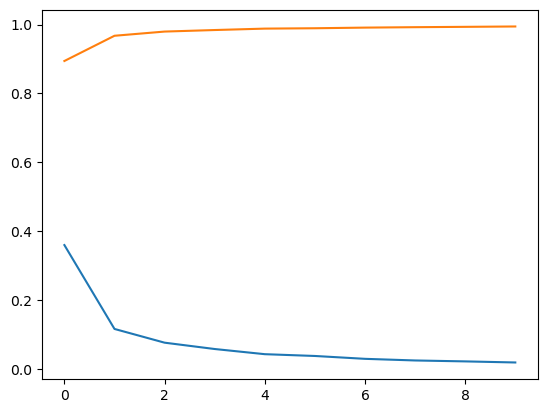

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

In [14]:
image_dir = "../equation_images/"

In [32]:
def getOverlap(a, b):
     return max(0, min(a[1], b[1]) - max(a[0], b[0]))
def detect_contours(img_path):
    # Given an image path, output bounding box coordinates of an image
    input_image = cv2.imread(img_path, 0) # Load a greyscale image
 
    # Make a copy to draw bounding box
    input_image_cpy = input_image.copy()

    # Convert the grayscale image to binary (image binarization opencv python), then invert
    binarized = cv2.adaptiveThreshold(input_image_cpy,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,3,10)
    inverted_binary_img = ~binarized

    # Create a kernel (tweak size for your dataset)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # 3x3 kernel

    # Use opening to remove small noise
    cleaned_img = cv2.morphologyEx(inverted_binary_img, cv2.MORPH_OPEN, kernel)

    # Use closing to connect broken parts of numbers
    cleaned_img = cv2.morphologyEx(cleaned_img, cv2.MORPH_CLOSE, kernel)

    # Detect contours
    # hierarchy variable contains information about the relationship between each contours
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE) # Find contours
    # Detect contours
    l = []
    for c in contours_list:
        x, y, w, h = cv2.boundingRect(c)
        l.append([x, y, w, h])
    # Check whether any overlapping rectangles. We do this in a way such that we only compare each box once with all other boxes.
    lcopy = l.copy()
    keep = []
    while len(lcopy) != 0:
        curr_x, curr_y, curr_w, curr_h = lcopy.pop(0) # Look at next box
        if curr_w * curr_h < 20: # remove very small boxes
            continue
        throw = []
        for i, (x, y, w, h) in enumerate(lcopy):
            curr_interval = [curr_x, curr_x+curr_w]
            next_interval = [x, x+w]
            if getOverlap(curr_interval, next_interval) > 1 : # more than 3 pixels overlap, this is arbitrary
                # Merge the two intervals
                new_interval_x = [min(curr_x, x), max(curr_x+curr_w, x+w)]
                new_interval_y = [min(curr_y, y), max(curr_y+curr_h, y+h)]
                newx, neww = new_interval_x[0], new_interval_x[1] - new_interval_x[0]
                newy, newh = new_interval_y[0], new_interval_y[1] - new_interval_y[0]
                curr_x, curr_y, curr_w, curr_h = newx, newy, neww, newh
                throw.append(i) # Mark this box to throw away later, since it has now been merged with current box
        for ind in sorted(throw, reverse=True): # Sort in reverse order otherwise we will pop incorrectly
            lcopy.pop(ind)
        keep.append([curr_x, curr_y, curr_w, curr_h]) # Keep the current box we are comparing against
    return keep

In [33]:
IMAGE = "2numbers_045.png"
img_path = "../equation_images/"+IMAGE
input_image = cv2.imread(img_path, 0) 
input_image_cpy = input_image.copy()
keep = detect_contours(image_dir+IMAGE)

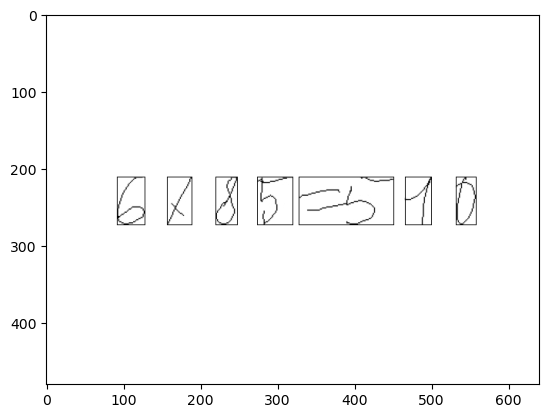

In [34]:
#Visualise how the bounding boxes look like
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_cpy, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(input_image_cpy, cmap='gray')
plt.show()